# Assess Performance on Polaris
The goal is to see if the single-GPU performance matches a local installation, and whether it can scale past one node.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import linregress
from ase.db import connect
import pandas as pd
import numpy as np

## Load in the data
Following the same pattern as [`compare-redox-potentials`](compare-redox-potentials.ipynb).

In [2]:
example_molecules = pd.read_csv('../data/example_molecules.csv')

In [3]:
mol_props = example_molecules.set_index('inchi_key').to_dict('index')

In [4]:
data = []
for psolver in ['mt-gpu', 'mt-polaris-serial', 'mt-polaris-parallel']:
    with connect(f'{psolver}/data.db') as db:
        for row in db.select(''):
            record = row.key_value_pairs.copy()
            record['basis_set'] = record['basis_set'].upper()
            record['n_electrons'] = mol_props[record['inchi_key']]['n_electrons']
            record['energy'] = row.energy
            record['solver'] = psolver
            record['gpus'] = row['num_nodes'] * 4 if psolver == "mt-polaris-parallel" else 1
            data.append(record)
data = pd.DataFrame(data)
print(f'Loaded {len(data)} computations')

Loaded 412 computations


Get only those with 500 cutoff and a buffer of 6

## Compare Runtimes of Single-GPU from Desktop to Polaris
My desktop has a GTX 3070 Ti, which should be slower than the A100 on Polaris

In [5]:
local_data = data.query('solver=="mt-gpu"')

In [6]:
single_data = data.query('solver=="mt-polaris-serial"')

In [7]:
merged = local_data.merge(single_data, on=('inchi_key', 'state', 'basis_set', 'cutoff', 'xc', 'n_electrons'))
merged['speedup'] = merged['runtime_x'] / merged['runtime_y']

In [8]:
merged['speedup'].describe()

count    50.000000
mean      1.107646
std       0.284844
min       0.731525
25%       0.981666
50%       1.070554
75%       1.167816
max       2.597756
Name: speedup, dtype: float64

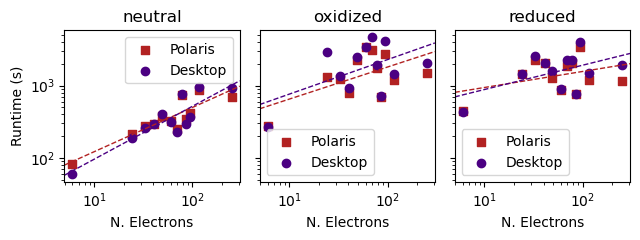

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(6.5, 2.5))

for ax, (state, group) in zip(axs, merged.groupby('state')):   
    subset = group.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='Polaris')
    wt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_y']))
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='Desktop')
    mt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_x']))
    
    # Set up the scale
    ax.set_title(state)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    
    # Plot the linear regressions
    ax.set_xlim(ax.get_xlim())
    ax.plot(ax.get_xlim(), np.exp(wt_linreg.intercept + wt_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(mt_linreg.intercept + mt_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_xlabel('N. Electrons')
axs[0].set_ylabel('Runtime (s)')
    
fig.tight_layout()

Runtimes are effectively the same, with polaris maybe 10% faster for larger molecules.

## Compare Scaling on Polaris
Make sure we get better performance using more than one GPU

In [10]:
polaris_data = data.query('solver!="mt-gpu"')

In [11]:
n_basis = len(polaris_data.basis_set.value_counts())

In [12]:
merged = polaris_data.merge(single_data, on=('inchi_key', 'state', 'basis_set', 'xc', 'n_electrons', 'cutoff'))
merged['speedup'] = merged['runtime_y'] / merged['runtime_x']

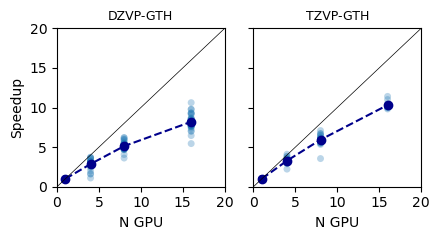

In [13]:
fig, axs = plt.subplots(1, n_basis, sharey=True, figsize=(4.5, 2.5))

for ax, (basis, group) in zip(axs, merged.groupby('basis_set')):
    subset = group.groupby('gpus_x').mean()

    # Plot the values
    ax.scatter(group['gpus_x'], group['speedup'], s=25, ec='none', alpha=.3)
    ax.plot(subset.index, subset['speedup'], '--o', color='darkblue')

    # Set up the scale
    ax.set_title(basis, fontsize=9)
    #ax.set_yscale('log', base=2)
    #ax.set_xscale('log', base=2)

    ax.set_xlabel('N GPU')
    ax.set_xlim(0, 20)
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.set_xlim(), ax.get_xlim(), 'k-', lw=0.5)

axs[0].set_ylabel('Speedup')
    
fig.tight_layout()

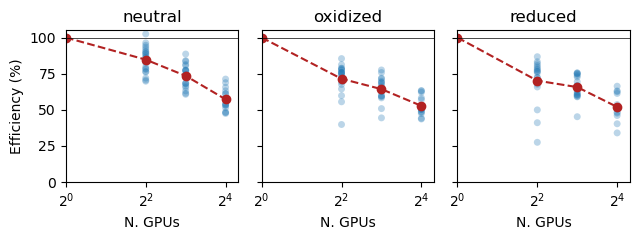

In [14]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(6.5, 2.5))

for ax, (state, group) in zip(axs, merged.groupby('state')):   
    subset = group.groupby('gpus_x').mean()
        
    # Plot the values
    ax.scatter(group['gpus_x'], group['speedup'] / group['gpus_x'] * 100, s=25, ec='none', alpha=.3)
    ax.plot(subset.index, subset['speedup'] / subset.index * 100, '--o', color='firebrick')
    
    # Set up the scale
    ax.set_title(state)
    #ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=2)
    
    ax.set_xlim(1, 20)
    ax.set_ylim([0, 105])
    ax.plot(ax.set_xlim(), [100]*2, 'k-', lw=0.5)
    
    ax.set_xlabel('N. GPUs')
axs[0].set_ylabel('Efficiency (%)')
    
fig.tight_layout()

We get a pretty sharp drop off in efficiency when moving from one to multiple GPUs